In [18]:
import json
from pathlib import Path
from datetime import datetime

import httpx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Load evaluation dataset
eval_dataset_path = Path("eval_dataset.json")
with open(eval_dataset_path, "r") as f:
    eval_dataset = json.load(f)

API_BASE = "http://127.0.0.1:8000"
ENDPOINTS = {
    "embedding_only": "/suggestions",
    "combined": "/suggestions/combined",
    "hybrid_pg": "/suggestions/hybrid"
}

reports_dir = Path("reports")
reports_dir.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

In [22]:
eval_df = pd.DataFrame(eval_dataset)

In [23]:
eval_df

,input_title,expected_title
0,software dev,Software Developers
1,java programmer,Computer Programmers
2,data scientist,Data Scientists
3,cybersecurity analyst,Information Security Analysts
4,mechanical engineer,Mechanical Engineers
...,...,...
136,florist,Floral Designers
137,baker,Bakers
138,pastry chef,Chefs and Head Cooks
139,butcher,Butchers and Meat Cutters


In [25]:
def evaluate_api(endpoint, params, eval_data):
    predictions = []
    with httpx.Client() as client:
        for _, row in eval_data.iterrows():
            q = row["input_title"]
            expected = row["expected_title"]
            try:
                resp = client.get(endpoint, params={**params, "q": q})
                resp.raise_for_status()
                results = resp.json().get("matches", [])
                if results:
                    top = results[0]
                    predictions.append({
                        "input": q,
                        "expected": expected,
                        "predicted": top["name"],
                        "score": top.get("embedding_score") or top.get("final_score"),
                        "correct": top["name"] == expected
                    })
                else:
                    predictions.append({
                        "input": q, "expected": expected, "predicted": None, "score": None, "correct": False
                    })
            except Exception:
                predictions.append({
                    "input": q, "expected": expected, "predicted": None, "score": None, "correct": False
                })

    df = pd.DataFrame(predictions)
    TP = df["correct"].sum()
    FP = len(df[(df["predicted"].notnull()) & (~df["correct"])])
    FN = len(df[df["predicted"].isnull()])

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    coverage = len(df[df["predicted"].notnull()]) / len(df)

    return df, {"precision": precision, "recall": recall, "f1": f1, "coverage": coverage}

In [29]:
df, metrics = evaluate_api(
    endpoint="http://127.0.0.1:8000/match/embedding", 
    params={
        "limit": 1,
        "embedding_score_threshold": 0.0
    },
    eval_data=eval_df
)
print(metrics)
df

{'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8, 'coverage': 1.0}


,input,expected,predicted,score,correct
0,software dev,Software Developers,Software Developers,0.857693,True
1,java programmer,Computer Programmers,Computer Programmers,0.711456,True
2,data scientist,Data Scientists,Data Scientists,0.958146,True
3,cybersecurity analyst,Information Security Analysts,Information Security Analysts,0.795615,True
4,mechanical engineer,Mechanical Engineers,Mechanical Engineers,0.971608,True
...,...,...,...,...,...
136,florist,Floral Designers,Floral Designers,0.671231,True
137,baker,Bakers,Bakers,0.875912,True
138,pastry chef,Chefs and Head Cooks,Chefs and Head Cooks,0.601943,True
139,butcher,Butchers and Meat Cutters,Butchers and Meat Cutters,0.735923,True


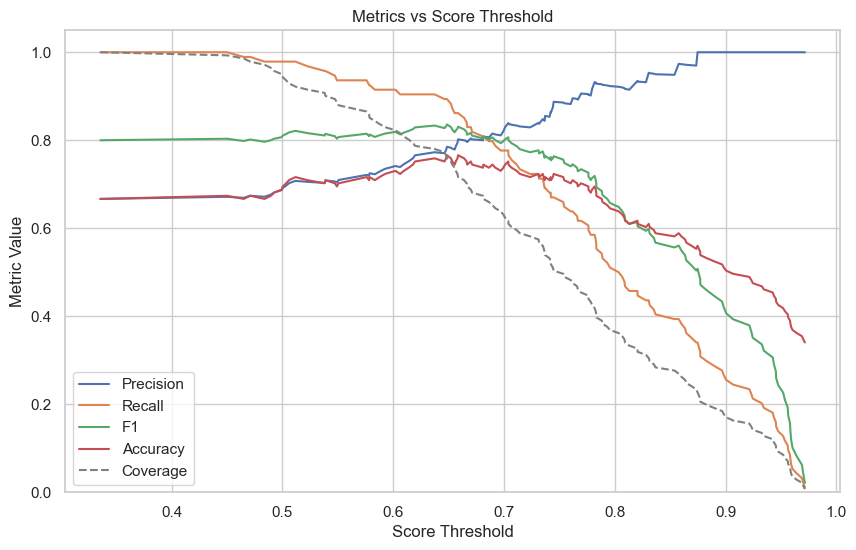

Best thresholds by metric:
precision: threshold=0.8747, value=1.0000
recall: threshold=0.3356, value=1.0000
f1: threshold=0.6485, value=0.8358
accuracy: threshold=0.6485, value=0.7660
coverage: threshold=0.3356, value=1.0000


In [32]:
df_sorted = df.sort_values("score").reset_index(drop=True)
thresholds = df_sorted["score"].tolist()

best_thresholds = {
    "precision": {"threshold": None, "value": -1},
    "recall": {"threshold": None, "value": -1},
    "f1": {"threshold": None, "value": -1},
    "accuracy": {"threshold": None, "value": -1},
    "coverage": {"threshold": None, "value": -1}
}

metrics = []
for t in thresholds:
    valid = df_sorted["score"] >= t
    TP = ((valid) & (df_sorted["correct"])).sum()
    FP = ((valid) & (~df_sorted["correct"])).sum()
    FN = ((~valid) & (df_sorted["correct"])).sum()
    TN = ((~valid) & (~df_sorted["correct"])).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / len(df_sorted)
    coverage = valid.mean()

    if precision > best_thresholds["precision"]["value"]:
        best_thresholds["precision"] = {"threshold": t, "value": precision}
    if recall > best_thresholds["recall"]["value"]:
        best_thresholds["recall"] = {"threshold": t, "value": recall}
    if f1 > best_thresholds["f1"]["value"]:
        best_thresholds["f1"] = {"threshold": t, "value": f1}
    if accuracy > best_thresholds["accuracy"]["value"]:
        best_thresholds["accuracy"] = {"threshold": t, "value": accuracy}
    if coverage > best_thresholds["coverage"]["value"]:
        best_thresholds["coverage"] = {"threshold": t, "value": coverage}

    metrics.append({
        "score": t,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "coverage": coverage
    })

metrics_df = pd.DataFrame(metrics)

# Plot metrics vs score
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["score"], metrics_df["precision"], label="Precision")
plt.plot(metrics_df["score"], metrics_df["recall"], label="Recall")
plt.plot(metrics_df["score"], metrics_df["f1"], label="F1")
plt.plot(metrics_df["score"], metrics_df["accuracy"], label="Accuracy")
plt.plot(metrics_df["score"], metrics_df["coverage"], label="Coverage", linestyle="--", color="gray")

plt.xlabel("Score Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Score Threshold")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

# Show best thresholds
print("Best thresholds by metric:")
for metric, data in best_thresholds.items():
    print(f"{metric}: threshold={data['threshold']:.4f}, value={data['value']:.4f}")

In [ ]:
def call_job_title_api(endpoint, )

In [10]:
def run_experiment(name, endpoint, params=None):
    params = params or {}
    predictions = {}

    with httpx.Client() as client:
        for row in eval_dataset:
            q = row["input_title"]
            try:
                response = client.get(API_BASE + endpoint, params={"q": q, **params})
                response.raise_for_status()

                if endpoint == "/suggestions":
                    suggestions = response.json().get("suggestions", [])
                    predictions[q] = suggestions[0]["name"] if suggestions else None
                else:
                    results = response.json().get("results", [])
                    predictions[q] = results[0]["title"] if results else None
            except Exception as e:
                predictions[q] = None

    y_true = [r["expected_title"] for r in eval_dataset]
    y_pred = [predictions[r["input_title"]] for r in eval_dataset]

    TP = sum((yt == yp) for yt, yp in zip(y_true, y_pred) if yp is not None)
    FP = sum((yt != yp) for yt, yp in zip(y_true, y_pred) if yp is not None)
    FN = sum((yp is None) for yp in y_pred)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    results_df = pd.DataFrame([
        {
            "input_title": r["input_title"],
            "expected": r["expected_title"],
            "predicted": predictions[r["input_title"]],
            "correct": predictions[r["input_title"]] == r["expected_title"]
        }
        for r in eval_dataset
    ])

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report = {
        "experiment_name": name,
        "endpoint": endpoint,
        "params": params,
        "timestamp": timestamp,
        "metrics": {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    }
    report_path = reports_dir / f"{name}_{timestamp}.json"
    with open(report_path, "w") as f:
        json.dump(report, f, indent=2)

    return name, precision, recall, f1, results_df


In [11]:
experiments = []
for name, endpoint in ENDPOINTS.items():
    display(Markdown(f"### Running **{name}**"))
    result = run_experiment(name, endpoint)
    experiments.append(result)

metrics_df = pd.DataFrame(
    [{"experiment": n, "precision": p, "recall": r, "f1": f} for n,p,r,f,_ in experiments]
)

display(metrics_df)

### Running **embedding_only**

### Running **combined**

### Running **hybrid_pg**

,experiment,precision,recall,f1
0,embedding_only,0.829545,0.579365,0.682243
1,combined,0.680851,1.000000,0.810127
2,hybrid_pg,0.701149,0.530435,0.603960


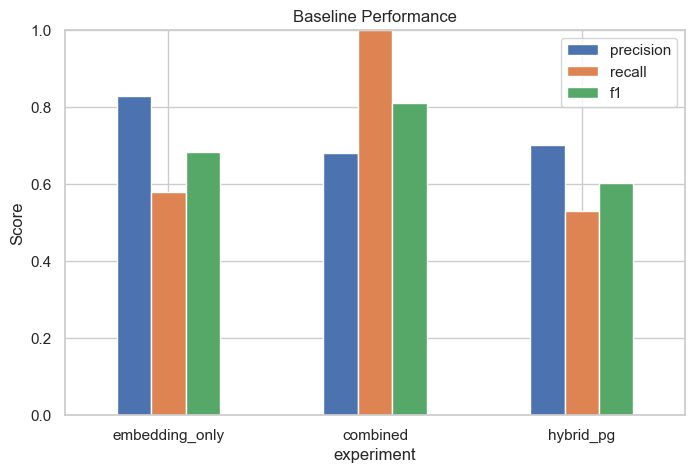

In [12]:
metrics_df.set_index("experiment")[["precision","recall","f1"]].plot(
    kind="bar", figsize=(8,5), title="Baseline Performance", rot=0
)
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()

In [13]:
embedding_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
weight_ratios = [(0.9,0.1),(0.8,0.2),(0.7,0.3),(0.6,0.4),(0.5,0.5)]

sweep_results = []

# Sweep embedding-only thresholds
for t in embedding_thresholds:
    _, p, r, f1, _ = run_experiment(f"embedding_t{t}", "/suggestions", params={"threshold": t})
    sweep_results.append({"method": "embedding_only", "param": t, "precision": p, "recall": r, "f1": f1})

# Sweep weights for combined and hybrid
for w1, w2 in weight_ratios:
    for method, endpoint in [("combined","/suggestions/combined"),("hybrid_pg","/suggestions/hybrid")]:
        _, p, r, f1, _ = run_experiment(f"{method}_{w1}_{w2}", endpoint, params={"embed_weight": w1, "fuzzy_weight": w2})
        sweep_results.append({"method": method, "param": f"{w1}:{w2}", "precision": p, "recall": r, "f1": f1})

df_sweep = pd.DataFrame(sweep_results)

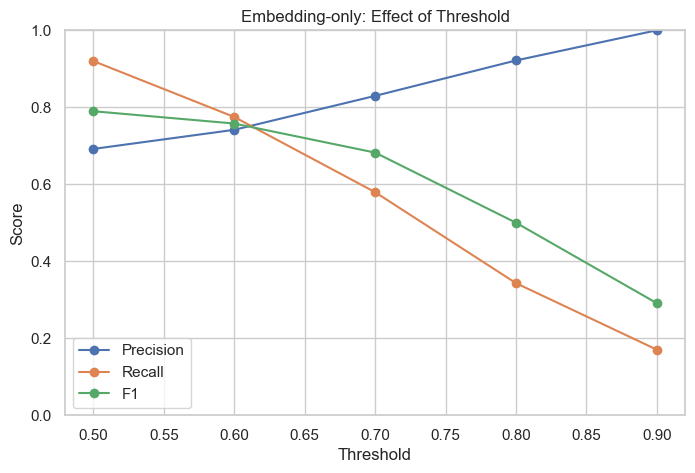

In [14]:
df_emb = df_sweep[df_sweep["method"]=="embedding_only"]
plt.figure(figsize=(8,5))
plt.plot(df_emb["param"], df_emb["precision"], marker="o", label="Precision")
plt.plot(df_emb["param"], df_emb["recall"], marker="o", label="Recall")
plt.plot(df_emb["param"], df_emb["f1"], marker="o", label="F1")
plt.title("Embedding-only: Effect of Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.ylim(0,1)
plt.show()

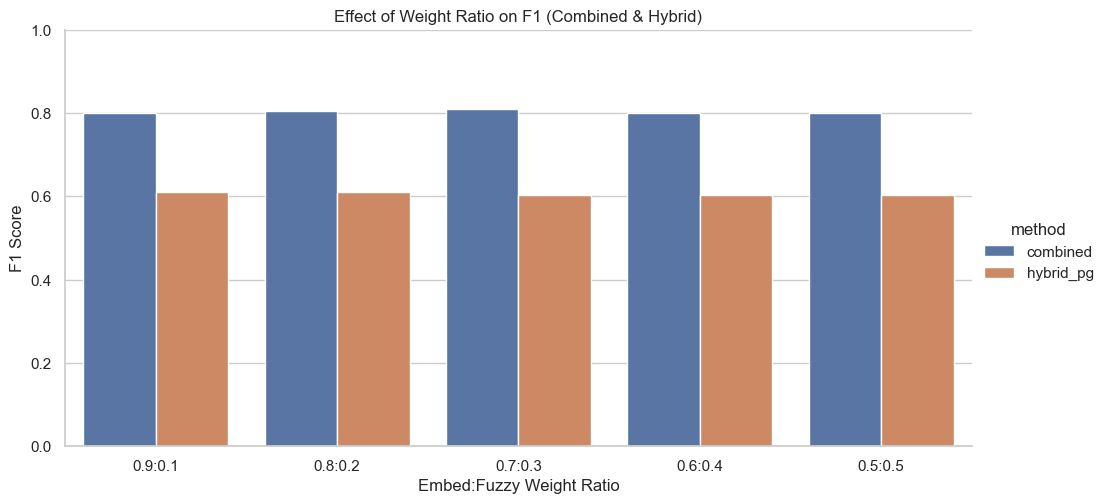

In [15]:
df_weights = df_sweep[df_sweep["method"].isin(["combined","hybrid_pg"])]
sns.catplot(
    data=df_weights, x="param", y="f1", hue="method",
    kind="bar", height=5, aspect=2
)
plt.title("Effect of Weight Ratio on F1 (Combined & Hybrid)")
plt.xlabel("Embed:Fuzzy Weight Ratio")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()


In [6]:
for name,_,_,_,df in experiments:
    incorrect = df[df["correct"] == False].head(10)
    display(Markdown(f"### Incorrect Predictions for {name}"))
    display(incorrect)


### Incorrect Predictions for embedding_only

,input_title,expected,predicted,correct
7,lab tech,Medical and Clinical Lab Technicians,Medical and Clinical Laboratory Technicians,False
10,rn,Registered Nurses,None,False
12,surgeon,Surgeons,Pediatric Surgeons,False
16,cna,Nursing Assistants,None,False
17,school nurse,Registered Nurses,None,False
18,school counselor,"Educational, Guidance, and Career Counselors a...",School Psychologists,False
20,math teacher,"Secondary School Teachers, Except Special and ...","Mathematical Science Teachers, Postsecondary",False
22,elementary teacher,Elementary School Teachers,None,False
23,special ed teacher,Special Education Teachers,"Special Education Teachers, Elementary School",False
25,preschool teacher,Preschool Teachers,"Preschool Teachers, Except Special Education",False


### Incorrect Predictions for combined

,input_title,expected,predicted,correct
7,lab tech,Medical and Clinical Lab Technicians,Medical and Clinical Laboratory Technicians,False
8,research assistant,Medical Assistants,Social Science Research Assistants,False
12,surgeon,Surgeons,Pediatric Surgeons,False
17,school nurse,Registered Nurses,Nurse Midwives,False
18,school counselor,"Educational, Guidance, and Career Counselors a...",School Psychologists,False
20,math teacher,"Secondary School Teachers, Except Special and ...","Mathematical Science Teachers, Postsecondary",False
22,elementary teacher,Elementary School Teachers,"Elementary School Teachers, Except Special Edu...",False
23,special ed teacher,Special Education Teachers,"Special Education Teachers, Elementary School",False
25,preschool teacher,Preschool Teachers,"Preschool Teachers, Except Special Education",False
26,college professor,Postsecondary Teachers,"Business Teachers, Postsecondary",False


### Incorrect Predictions for hybrid_pg

,input_title,expected,predicted,correct
7,lab tech,Medical and Clinical Lab Technicians,None,False
8,research assistant,Medical Assistants,Social Science Research Assistants,False
10,rn,Registered Nurses,None,False
11,family doctor,Family Medicine Physicians,None,False
12,surgeon,Surgeons,Pediatric Surgeons,False
15,vet tech,Veterinary Technologists and Technicians,None,False
16,cna,Nursing Assistants,None,False
17,school nurse,Registered Nurses,None,False
18,school counselor,"Educational, Guidance, and Career Counselors a...",Credit Counselors,False
20,math teacher,"Secondary School Teachers, Except Special and ...",None,False
